In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np


In [2]:
# Import and read the healthcare-dataset-stroke-data.csv.
import pandas as pd 
stroke_df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## EDA & Preprocessiong

In [3]:
# dataframe information
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
# checking for NaNs in each column
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# create a series of avg BMI for each age
avg_bmi_by_age = stroke_df.groupby("age")["bmi"].mean()
avg_bmi_by_age

age
0.08     15.500000
0.16     14.766667
0.24     17.400000
0.32     18.080000
0.40     15.850000
           ...    
78.00    27.929032
79.00    27.862338
80.00    28.783582
81.00    27.951667
82.00    28.029091
Name: bmi, Length: 104, dtype: float64

In [7]:
# replace NaNs in BMI column with "avg_bmi_by_age" for the corresponding age
def replace_bmi(row):
    if pd.isna(row["bmi"]):
        return avg_bmi_by_age[row["age"]]
    else:
        return row["bmi"]
    
stroke_df["bmi"] = stroke_df.apply(replace_bmi, axis = 1)

In [8]:
# checking for NaNs for BMI column
stroke_df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
# Drop the Id column as Id column has no impact on data analysis
stroke_df = stroke_df.drop(columns = ["id"])
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.19,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [10]:
# checking unique value in each column
stroke_df.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   487
smoking_status          4
stroke                  2
dtype: int64

In [11]:
# gender value counts
stroke_df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [12]:
# drop "other from stroke_df["gender"] column since it's just 1 record
stroke_df = stroke_df.drop(stroke_df[stroke_df["gender"] == "Other"].index)

In [13]:
# check is the "other" is droped
stroke_df["gender"].unique()

array(['Male', 'Female'], dtype=object)

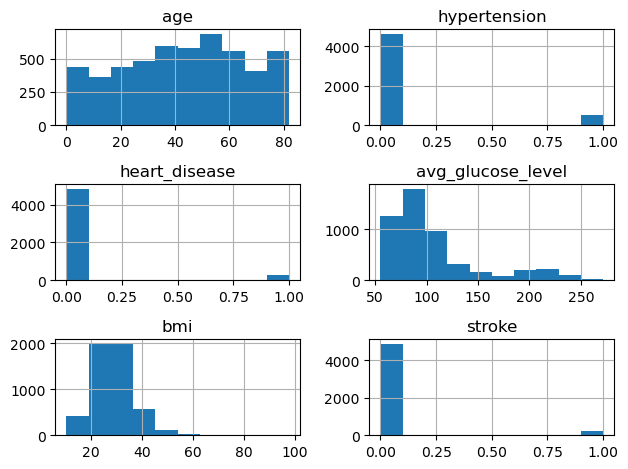

In [14]:
# to check how the data is destributed
stroke_df.hist()
plt.tight_layout()

Text(0.5, 1.0, 'Gender Distribution')

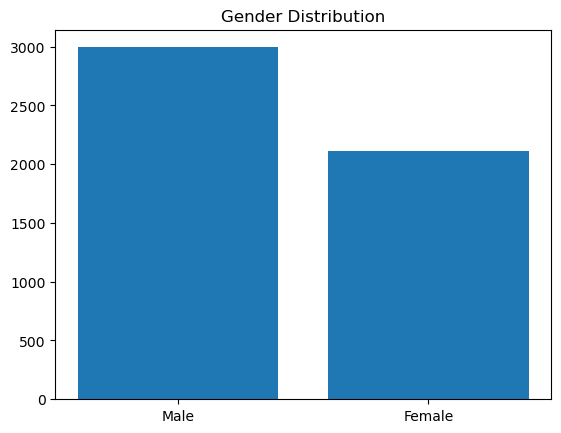

In [15]:
# Examine the distribution of gender column
plt.bar(stroke_df['gender'].unique(), stroke_df['gender'].value_counts())
plt.title('Gender Distribution')

Text(0.5, 1.0, 'Work Effects on Stroke')

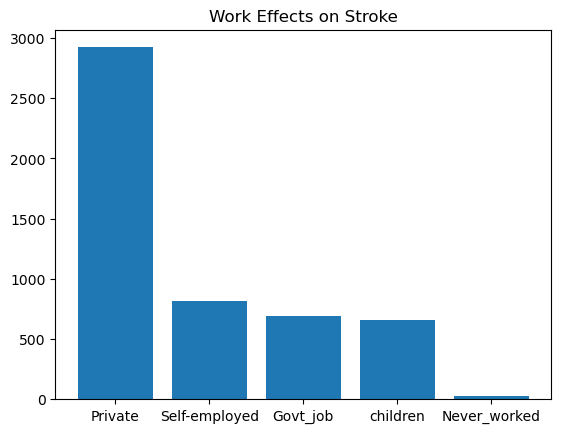

In [16]:
# Examine the distribution of work type column
plt.bar(stroke_df['work_type'].unique(), stroke_df['work_type'].value_counts())
plt.title('Work Effects on Stroke')

Text(0.5, 1.0, 'Smoking Effects on Stroke')

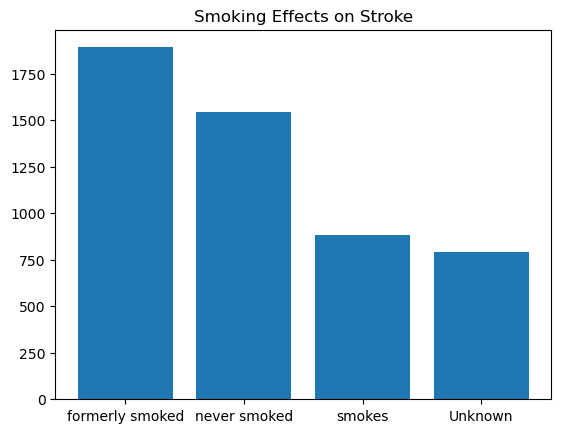

In [17]:
# Examine the distribution of smoked or not column
plt.bar(stroke_df['smoking_status'].unique(), stroke_df['smoking_status'].value_counts())
plt.title('Smoking Effects on Stroke')

<BarContainer object of 2 artists>

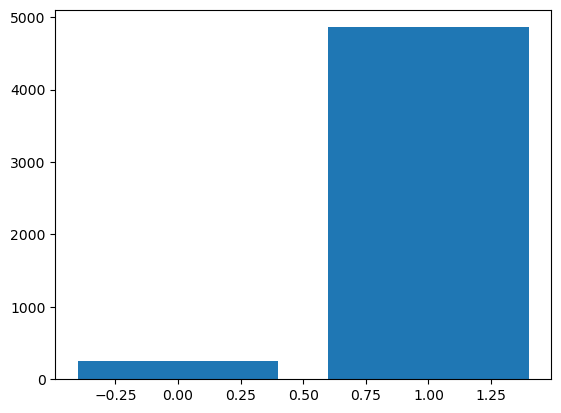

In [18]:
# Examine the distribution of stroke column
plt.bar(stroke_df['stroke'].unique(), stroke_df['stroke'].value_counts())

#### As we can see from the above bar chart that out target variable distribution is imbalanced. Peaple having no stroke is i minority.
* For this optimization I am going to use RandomOverSampler to balance out the minority dataset.

### Separate the Features (X) from the Target (y)

In [19]:
y = stroke_df["stroke"]
X = stroke_df.drop(columns = "stroke")
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.19,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked


In [20]:
# Convert categorical data to numeric with `pd.get_dummies` 
X_encoded = pd.get_dummies(X)
X_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,30.19,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.40,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.00,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0


### Handle imbalanced dataset using RandomOverSampler

In [21]:
# Perform oversampling with RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

In [22]:
from collections import Counter

print(f" Before SMOTE :", Counter(y))
print(f" After SMOTE :", Counter(y_ros))

 Before SMOTE : Counter({0: 4860, 1: 249})
 After SMOTE : Counter({1: 4860, 0: 4860})


In [23]:
# Convert categorical data to numeric with `pd.get_dummies` (only on X, bc y is already 0s and 1s)
X_encoded = pd.get_dummies(X_ros)

### Scale the data using Scaler

In [26]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit_transform(X_encoded)


### Split the data into train and test dataset

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_ros, random_state = 1)


In [28]:
print(X_train.shape)
print(X_test.shape)
print(X.shape)

(7290, 20)
(2430, 20)
(5109, 10)


### Train and Evaluate the Model

In [29]:
# Instantiate a Random Forest Classifier model
dt_model = tree.DecisionTreeClassifier()

### Train Model using the train data

In [30]:
# Fit the model with training data
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

### Make Prediction

In [31]:
# Make predictions on the test set
predictions = dt_model.predict(X_test)

In [32]:
# calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index = ["Actual No Stroke","Actual Yes Stroke"],
                    columns = ["Predicted No Stroke", "Predicted Yes Stroke"])
cm_df

acc_score = accuracy_score(y_test, predictions)

In [33]:
# Look at the accuracy score 
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.971604938271605


### Calculate the Accuracy Score

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions  )

0.971604938271605

In [35]:

# Look at the classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1209
           1       0.95      1.00      0.97      1221

    accuracy                           0.97      2430
   macro avg       0.97      0.97      0.97      2430
weighted avg       0.97      0.97      0.97      2430



**Summury :** In conclusion, the machine learning model showed good performance in the classification of stroke. It achieved high precision, recall, and F1-scores for both stroke and non-stroke instances, although the precision for stroke cases was slightly lower. The model's accuracy of 97% suggests its ability to effectively identify stroke cases. These findings indicate that the model has potential utility in assisting healthcare professionals with stroke diagnosis and detection. However, further analysis and refinement may be necessary to enhance the precision for stroke prediction and ensure reliable performance across diverse datasets and real-world scenarios.
* Precision:
The precision for class 0 (non-stroke) was found to be 1.00 (or 100%). This indicates that the model accurately predicted non-stroke instances with high precision.
The precision for class 1 (stroke) was determined to be 0.95 (or 95%), indicating that the model had a slightly lower precision for identifying stroke cases.
* Recall:
The recall for class 0 was observed to be 0.94 (or 94%), indicating that the model successfully identified 94% of the non-stroke instances.
The recall for class 1 was found to be 1.00 (or 100%), suggesting that the model correctly identified all instances of stroke.